In [10]:
import pandas as pd
pd.set_option("display.max_columns", 30)
import os
import glob
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

DATA_PATH = os.path.join( os.path.abspath(""), "../data" )

review_data_paths = glob.glob(os.path.join(DATA_PATH, 'review', '*.csv'))

In [139]:
diner = pd.read_csv(os.path.join(DATA_PATH, "diner_df_20241118_yamyam.csv"))
review = pd.DataFrame()
for review_data_path in review_data_paths:
    review = pd.concat([review, pd.read_csv(review_data_path)], axis=0)


/tmp/ipykernel_1977941/2754461911.py:4: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [117]:
diner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63553 entries, 0 to 63552
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   diner_idx                   63553 non-null  int64  
 1   diner_name                  63553 non-null  object 
 2   diner_category_large        63553 non-null  object 
 3   diner_category_middle       63505 non-null  object 
 4   diner_category_small        50965 non-null  object 
 5   diner_category_detail       17173 non-null  object 
 6   diner_tag                   44816 non-null  object 
 7   diner_menu                  63553 non-null  object 
 8   diner_menu_name             63553 non-null  object 
 9   diner_menu_price            63553 non-null  object 
 10  diner_review_cnt            63553 non-null  int64  
 11  diner_blog_review_cnt       63553 non-null  float64
 12  diner_review_avg            63553 non-null  float64
 13  diner_review_tags           398

In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 929537 entries, 0 to 370400
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      929537 non-null  int64  
 1   reviewer_id                    929537 non-null  int64  
 2   reviewer_review_cnt            929537 non-null  object 
 3   reviewer_avg                   929537 non-null  float64
 4   reviewer_review_score          929537 non-null  float64
 5   reviewer_review                779019 non-null  object 
 6   reviewer_review_date           929537 non-null  object 
 7   reviewer_user_name             928290 non-null  object 
 8   badge_grade                    929537 non-null  object 
 9   badge_level                    929537 non-null  int64  
 10  diner_idx                      929537 non-null  int64  
 11  reviewer_collected_review_cnt  559268 non-null  float64
dtypes: float64(3), int64(4), object(5)


In [140]:
diner.shape, review.shape

((63553, 26), (929537, 12))

In [141]:
# 중복행 여부 확인 -> 없음
diner.drop_duplicates().shape, review.drop_duplicates().shape

((63553, 26), (929537, 12))

In [142]:
# diner 데이터에서 diner_idx가 중복해서 존재하는게 있는지 확인 -> 없음
diner["diner_idx"].unique().shape

(63553,)

In [143]:
# review 데이터에서 diner_idx와 reviewer_id의 unique 수
# diner_df에서 diner_idx의 unique 수는 37408개였으나 리뷰를 받은 식당은 29206개임
# 즉, 37408 - 29206개의 식당은 리뷰를 1개도 받지 못한 식당임을 알 수 있음.
review["diner_idx"].unique().shape, review["reviewer_id"].unique().shape

((48133,), (304521,))

In [144]:
# 후기가 na인 행의 개수 -> 대략 17% 정도는 리뷰 텍스트를 쓰지 않고 리뷰 점수만 달았음.
total_reviews, _ = review.shape
na_review2cnt = review["reviewer_review"].map(lambda x: pd.isna(x)).value_counts().to_dict()
print(f"NA 리뷰 비율: {na_review2cnt[True] / total_reviews}")

NA 리뷰 비율: 0.16192792755963453


In [145]:
# review 점수가 na인 행의 개수 -> 모든 리뷰에 리뷰 점수가 있음!
print(f"NA 리뷰 점수의 수: {sum(review['reviewer_review_score'].map(lambda x: pd.isna(x)))}")

NA 리뷰 점수의 수: 0


In [20]:
# 주요 칼럼의 분포를 boxplot을 통해 살펴보자.
# 1사분위, 2사분위, 3사분위수도 함께 살펴보자.
def check_distribution(cnt, title):
    """
    cnt: List[int]
    """

    sns.boxplot(cnt)
    plt.title(title)
    plt.show()
    
    print(f"1사분위수: {np.quantile(cnt, 0.25)}")
    print(f"2사분위수: {np.quantile(cnt, 0.5)}")
    print(f"3사분위수: {np.quantile(cnt, 0.75)}")

    
diner2review_cnt = review["diner_idx"].value_counts().to_dict()
reviewer2review_cnt = review["reviewer_id"].value_counts().to_dict()

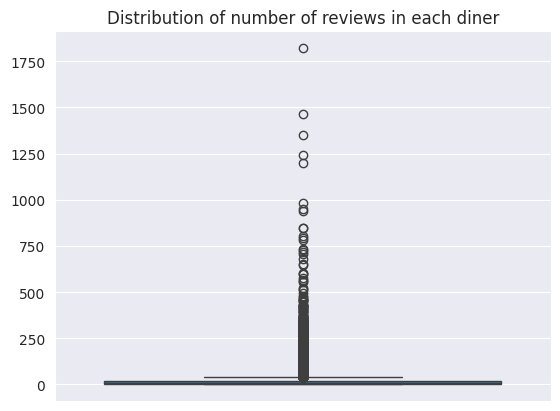

1사분위수: 4.0
2사분위수: 9.0
3사분위수: 19.0


In [15]:
# 각 음식점의 리뷰 수 분포
check_distribution(list(diner2review_cnt.values()), title="Distribution of number of reviews in each diner")

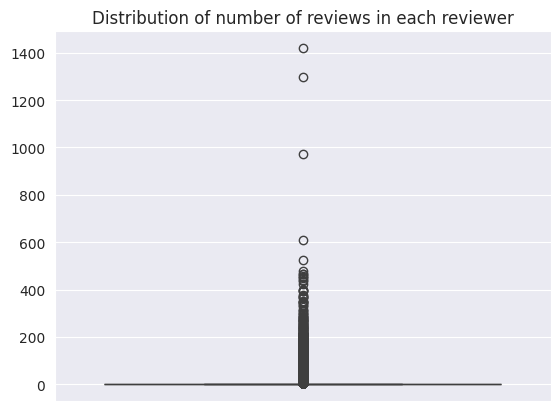

1사분위수: 1.0
2사분위수: 1.0
3사분위수: 2.0


In [21]:
# 각 리뷰어의 리뷰 수 분포
check_distribution(list(reviewer2review_cnt.values()), title="Distribution of number of reviews in each reviewer")

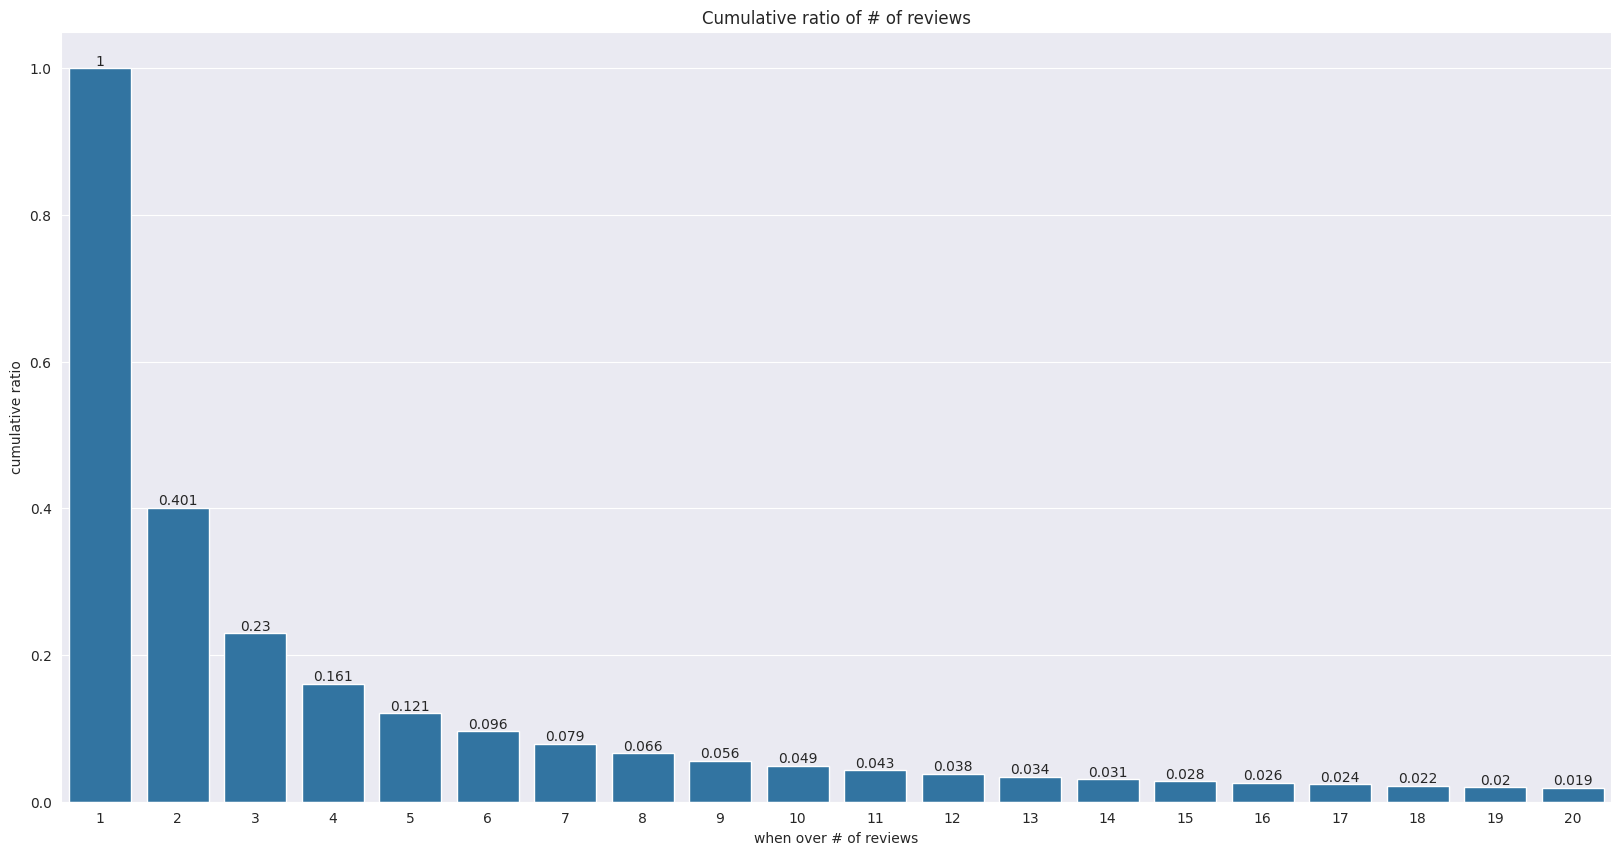

In [22]:
# 각 리뷰어의 리뷰 수 분포를 조금 더 자세하게 살펴보자.

total_reviewer = review["reviewer_id"].unique().shape[0]
cnts = [] # 리뷰 1개쓴 리뷰어의 수, 리뷰 2개 쓴 리뷰어의 수... 를 담을 list

for cnt in range(1,20):
    cnts.append(len([reviewer_id for reviewer_id, num_reviews in reviewer2review_cnt.items() if num_reviews == cnt]))

cnts.append(len([reviewer_id for reviewer_id, num_reviews in reviewer2review_cnt.items() if num_reviews >= cnt+1]))

assert total_reviewer == sum(cnts)

cnts = [ round(cnt/total_reviewer, 3) for cnt in np.cumsum(cnts[::-1])][::-1] # 리뷰 1개 이상 쓴 리뷰어의 수, 리뷰 2개 이상 쓴 리뷰어의 수 ...을 담을 list
num_reviews_df = pd.DataFrame({"label":[ str(i+1) for i in range(20) ], "cnts":cnts})

# 앞서 살펴봤듯이, 리뷰를 1개만 쓴 사람이 66%정도로, 2사분위수를 넘음.
# 만약에 리뷰를 5개 이상 작성한 사람만 training / test 데이터에 포함한다면 전체 리뷰어의 10% 정도로, 대략 2만명 정도임
# 리뷰를 몇개 이상 작성한 사람을 test data로 할지 논의가 필요해보임
plt.figure(figsize=(20,10))
ax = sns.barplot(x="label", y="cnts", data=num_reviews_df)
ax.bar_label(ax.containers[0])
plt.title("Cumulative ratio of # of reviews")
plt.ylabel("cumulative ratio")
plt.xlabel("when over # of reviews")
# map ndcg 평가지표
plt.show()

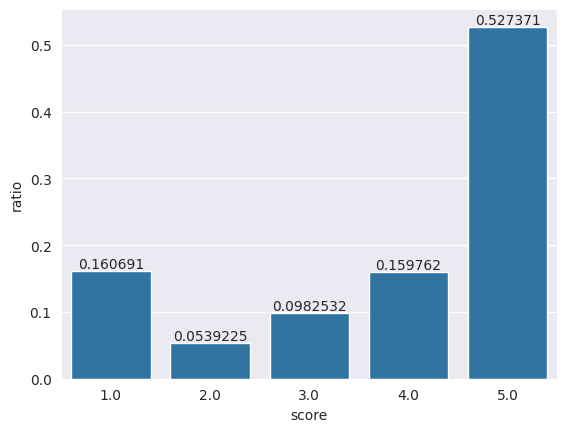

In [23]:
# review 점수대별 분포
total_reviews, _ = review.shape
review_score_ratio_df = (review["reviewer_review_score"].value_counts() / total_reviews).to_frame().reset_index()
review_score_ratio_df.columns = ["score", "ratio"]
ax = sns.barplot(x="score", y="ratio", data=review_score_ratio_df)
ax.bar_label(ax.containers[0])
plt.show()

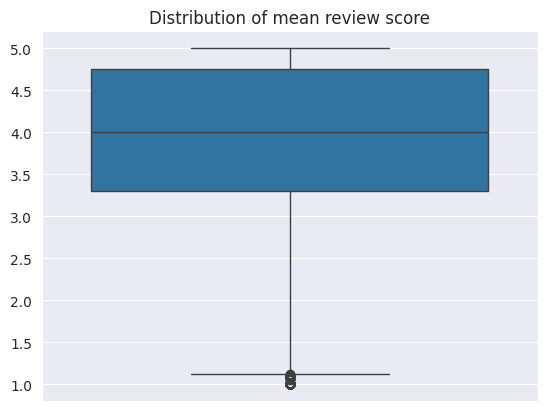

1사분위수: 3.3
2사분위수: 4.0
3사분위수: 4.75


In [24]:
# 리뷰어들의 평균 리뷰 점수 분포 (3건 이상의 리뷰를 남긴 사람만)
reviewer_id_over_3 = [reviewer_id for reviewer_id,cnt in reviewer2review_cnt.items() if cnt >= 3]
review_over_3 = review[lambda x: x["reviewer_id"].isin(reviewer_id_over_3)]

reviewer_id2mean_score = review_over_3.groupby("reviewer_id")["reviewer_review_score"].mean().to_dict()

check_distribution(list(reviewer_id2mean_score.values()), title="Distribution of mean review score")

In [25]:
# 전체 리뷰 길이의 분포 (na인 리뷰 제외)
review_text = review[lambda x: ~x["reviewer_review"].map(lambda x: pd.isna(x))]["reviewer_review"].tolist()
review_text_len = [len(text) for text in review_text]

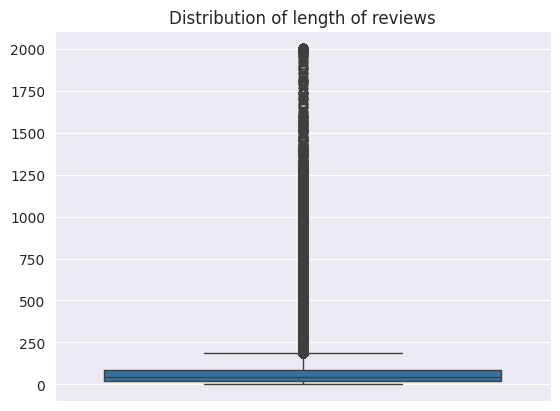

1사분위수: 21.0
2사분위수: 45.0
3사분위수: 88.0


In [26]:
check_distribution(review_text_len, title="Distribution of length of reviews")

## 지역 분석

In [46]:
# 리뷰가 있는 음식점 

# 1. df_geo_filtered에서 diner_idx 값이 있는 행의 diner_idx 리스트 추출
valid_review_idx = review['diner_idx'].dropna().unique()

# 2. review_df에서 diner_idx가 valid_diner_idx에 포함된 행만 필터링
diner_filtered = diner[diner['diner_idx'].isin(valid_review_idx)]

In [47]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: 리뷰가 있는 음식점의 분포 계산
district_counts_reviewed = diner_filtered['diner_address_constituency'].value_counts()
district_counts_reviewed.name = 'Reviewed_Count'

# Step 2: 전체 음식점의 분포 계산
district_counts_total = diner['diner_address_constituency'].value_counts()
district_counts_total.name = 'Total_Count'

# Step 3: 데이터 병합
merged_counts = pd.concat([district_counts_total, district_counts_reviewed], axis=1).fillna(0)

# Step 4: Plotly 시각화
fig = go.Figure()

# 리뷰가 있는 음식점 수 (stacked part)
fig.add_trace(go.Bar(
    x=merged_counts.index,
    y=merged_counts['Reviewed_Count'],
    name='Reviewed Restaurants'
))

# 리뷰가 없는 음식점 수 (difference between Total and Reviewed)
fig.add_trace(go.Bar(
    x=merged_counts.index,
    y=merged_counts['Total_Count'] - merged_counts['Reviewed_Count'],
    name='no Reviewed Restaurants'
))

# 레이아웃 설정
fig.update_layout(
    title='Stacked Distribution of Restaurants by District',
    xaxis_title='District',
    yaxis_title='Number of Restaurants',
    barmode='stack',  # 막대들을 겹쳐서 표시
    xaxis_tickangle=80  # X축 레이블 회전
)

# 그래프 출력
fig.show()


## 업태 category 분석

In [51]:
diner_filtered['diner_category_middle'].value_counts()

diner_category_middle
한식         19518
술집          5066
간식          4196
양식          3799
일식          3152
분식          2989
중식          2623
치킨          2320
패스트푸드       1091
아시아음식       1063
퓨전요리         551
샤브샤브         449
샐러드          424
뷔페           391
도시락          321
패밀리레스토랑       78
기사식당          39
구내식당          24
푸드코트          17
철판요리           5
야식             4
Name: count, dtype: int64

In [52]:
import pandas as pd
import plotly.express as px

# Step 1: diner_category_middle의 분포 계산
category_counts = diner_filtered['diner_category_middle'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Step 2: Plotly 시각화
fig = px.bar(
    category_counts,
    x='Category',
    y='Count',
    title='Distribution of Categories in diner_category_middle',
    labels={'Category': 'Category', 'Count': 'Number of Restaurants'},
    text='Count'
)

# Step 3: 그래프 커스터마이징
fig.update_traces(textposition='outside')  # 막대 외부에 숫자 표시
fig.update_layout(
    xaxis_tickangle=45,  # X축 레이블 회전
    showlegend=False,  # 범례 비활성화 (단일 데이터)
    yaxis_title='Number of Restaurants'
)

# 그래프 출력
fig.show()


In [53]:
import pandas as pd
import plotly.express as px

# Step 1: diner_category_small 우선순위로 값을 결정
diner_filtered['category_final'] = diner_filtered['diner_category_small'].fillna(diner_filtered['diner_category_middle'])

# Step 2: category_final의 분포 계산
category_counts = diner_filtered['category_final'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Step 3: Plotly 시각화
fig = px.bar(
    category_counts,
    x='Category',
    y='Count',
    title='Distribution of Categories (Using Small or Middle)',
    labels={'Category': 'Category', 'Count': 'Number of Restaurants'},
    text='Count'
)

# Step 4: 그래프 커스터마이징
fig.update_traces(textposition='outside')  # 막대 외부에 숫자 표시
fig.update_layout(
    xaxis_tickangle=45,  # X축 레이블 회전
    showlegend=False,  # 범례 비활성화 (단일 데이터)
    yaxis_title='Number of Restaurants'
)

# 그래프 출력
fig.show()


/tmp/ipykernel_1977941/2331959446.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## menu, price 분석

In [146]:
import pandas as pd
import ast

def safe_string_to_list(input_string, column_name):
    """
    안전하게 문자열을 리스트로 변환 (JSON이나 Python 리스트 형식 모두 처리 가능)
    
    Args:
        input_string (str): 리스트 형식의 문자열
        column_name (str): 현재 컬럼 이름
        
    Returns:
        list: 변환된 리스트 (변환 실패 시 빈 리스트 반환)
    """
    try:
        # 문자열을 리스트로 안전하게 변환
        input_list = ast.literal_eval(input_string)
        
        # 특정 컬럼에 대해 추가 처리
        if column_name == 'diner_menu_price':
            # 빈 문자열 제외하고 정수로 변환
            return [int(x) for x in input_list if x != '']
        else:
            return [x for x in input_list if x != '']

    except (ValueError, SyntaxError, TypeError):
        # 변환 실패 시 빈 리스트 반환
        return []

# 함수 적용
diner['diner_menu_name'] = diner['diner_menu_name'].apply(lambda x: safe_string_to_list(x, 'diner_menu_name'))
diner['diner_menu_price'] = diner['diner_menu_price'].apply(lambda x: safe_string_to_list(x, 'diner_menu_price'))


In [147]:
diner['diner_menu_name']

0          [쇼유라멘, 미소라멘, 돈코츠라멘, 니꾸라멘, 냉라멘 (7월~9월) 판매, 시오라멘]
1                    [방배김밥, 옛맛김밥, 참치김밥, 쉐프떡볶이, 쉐프라멘, 쉐프우동]
2        [여우김밥, 계란야채김밥, 계란소세지김밥, 계란새우튀김김밥, (NEW)소고기김밥, ...
3                                   [토리 빠이탄 라멘, 카라 빠이탄 라멘]
4        [모듬꼬치(6p), 모듬꼬치(11p), 팽이버섯 삼겹살(2ps), 토마토 삼겹살(2...
                               ...                        
63548                          [수제생갈비(280g), 수제양념갈비(300g)]
63549               [된장찌개, 가브리살, 짚불삼겹살, 짚불목살, 짚불항정살, 돼지꼬리]
63550    [꽃등심 (100g), 살치살 (100g), 치마살 (100g), 갈비살 (100g...
63551          [돼지물갈비(1인), 닭한마리, 급냉삼겹살인(1인), 닭한마리김치, 닭볶음탕]
63552                        [매운돼지갈비찜 (1인분), 매운소갈비찜 (1인분)]
Name: diner_menu_name, Length: 63553, dtype: object